# XGBoost

In [1]:
%pip install -q pandas matplotlib numpy scikit-learn ace_tools panelsplit shap upgrade jupyter ipywidgets xgboost
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement upgrade (from versions: none)
ERROR: No matching distribution found for upgrade


Looking in indexes: https://download.pytorch.org/whl/cu118Note: you may need to restart the kernel to use updated packages.



In [2]:
%pip install --upgrade xgboost


Note: you may need to restart the kernel to use updated packages.


In [3]:
import xgboost as xgb
import torch
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

import zipfile
import os

from panelsplit.cross_validation import PanelSplit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterSampler
from tqdm import tqdm

import random

c:\Users\cpedr\anaconda3\envs\nlp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0))


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

CUDA Available: True
GPU Name: NVIDIA GeForce RTX 2070 with Max-Q Design
Using device: cuda


In [4]:
# Define file names
csv_filename = "../final_df.csv"
zip_filename = "../final_df.zip"

# Extract the CSV file from the ZIP
with zipfile.ZipFile(zip_filename, 'r') as zipf:
    zipf.extract(csv_filename)

# Read the CSV file into a DataFrame
final_df = pd.read_csv("final_df.csv")

# Delete the extracted CSV file after reading
os.remove("final_df.csv")

100


c:\Users\cpedr\anaconda3\envs\nlp\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\cpedr\anaconda3\envs\nlp\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


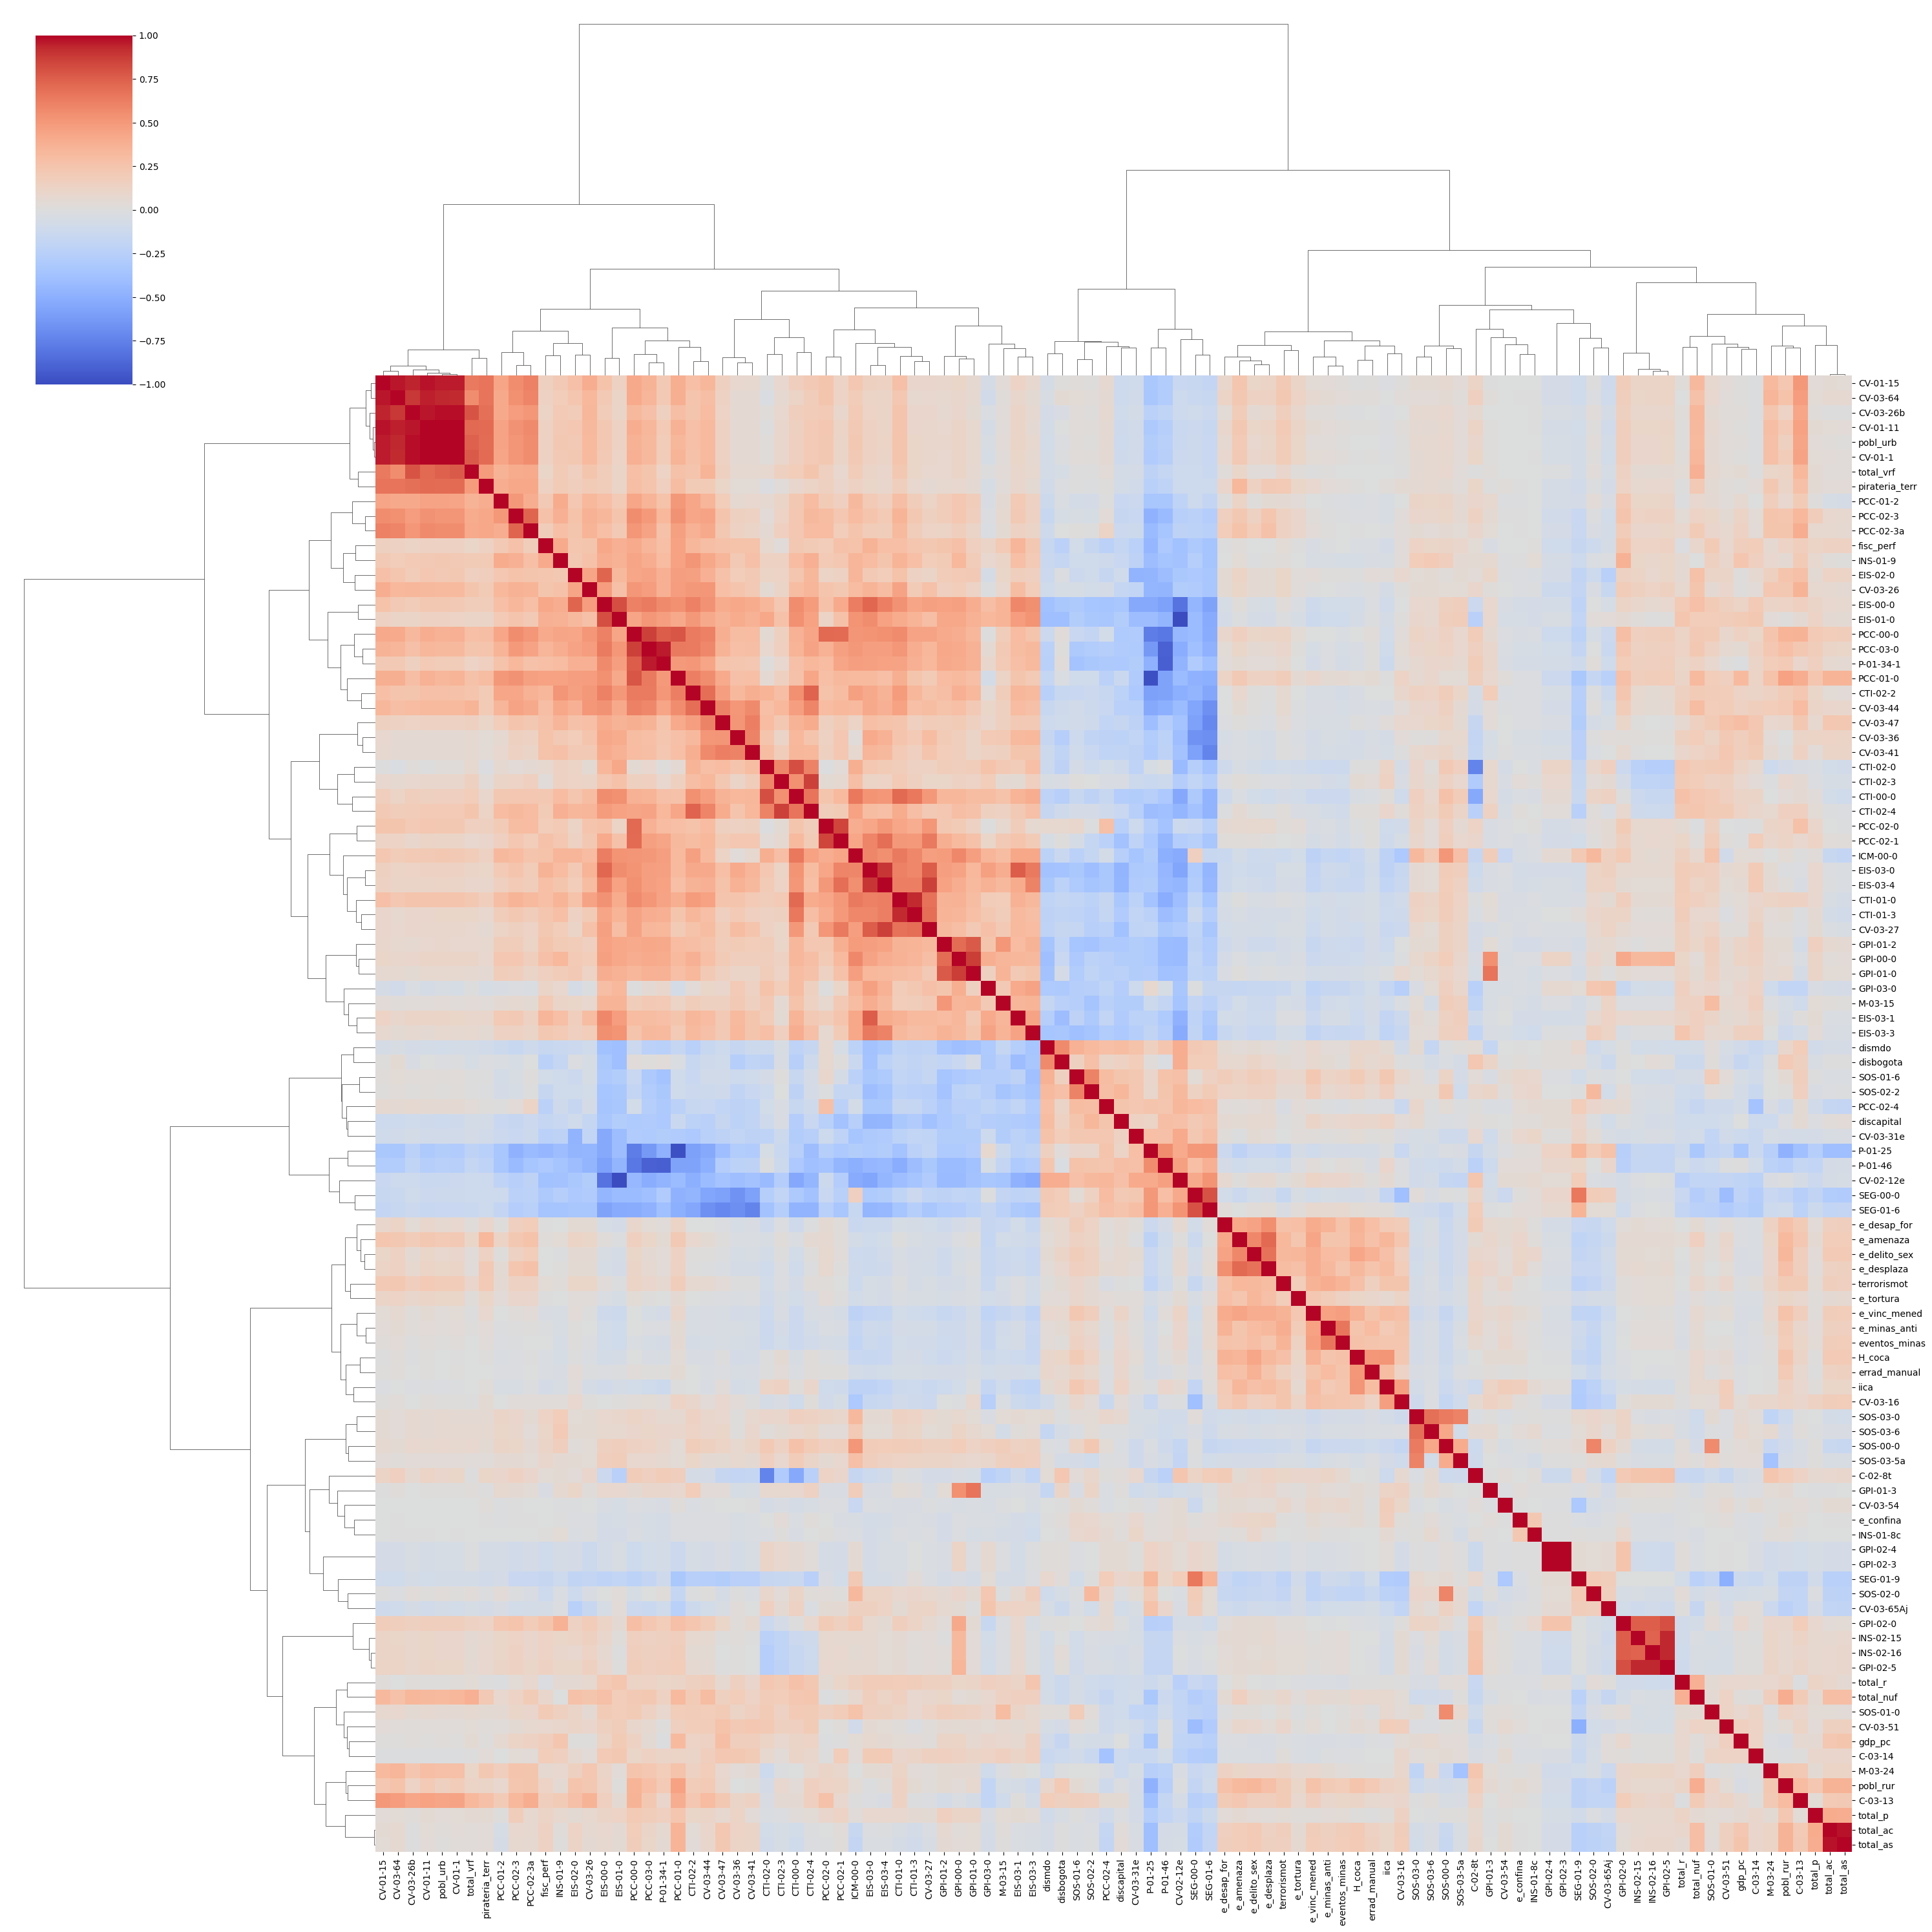

In [5]:
#Getting rid of redundant columns

X1 = final_df.drop(columns=['year', 'codmpio', 'cluster_kmeans', 'Departamento', 'Municipio', 'Region', 'pc_loss', 'f_loss', 'areaoficialhm2', 'gdp']) # GDP, area already out since the were already considered
print(len(X1.columns))
# Compute the correlation matrix
corr_matrix = X1.corr()

# Plot the correlation matrix
sns.clustermap(corr_matrix, 
               method='ward',  # or 'complete', 'average'
               cmap='coolwarm',
               figsize=(30, 30))
plt.show()

71


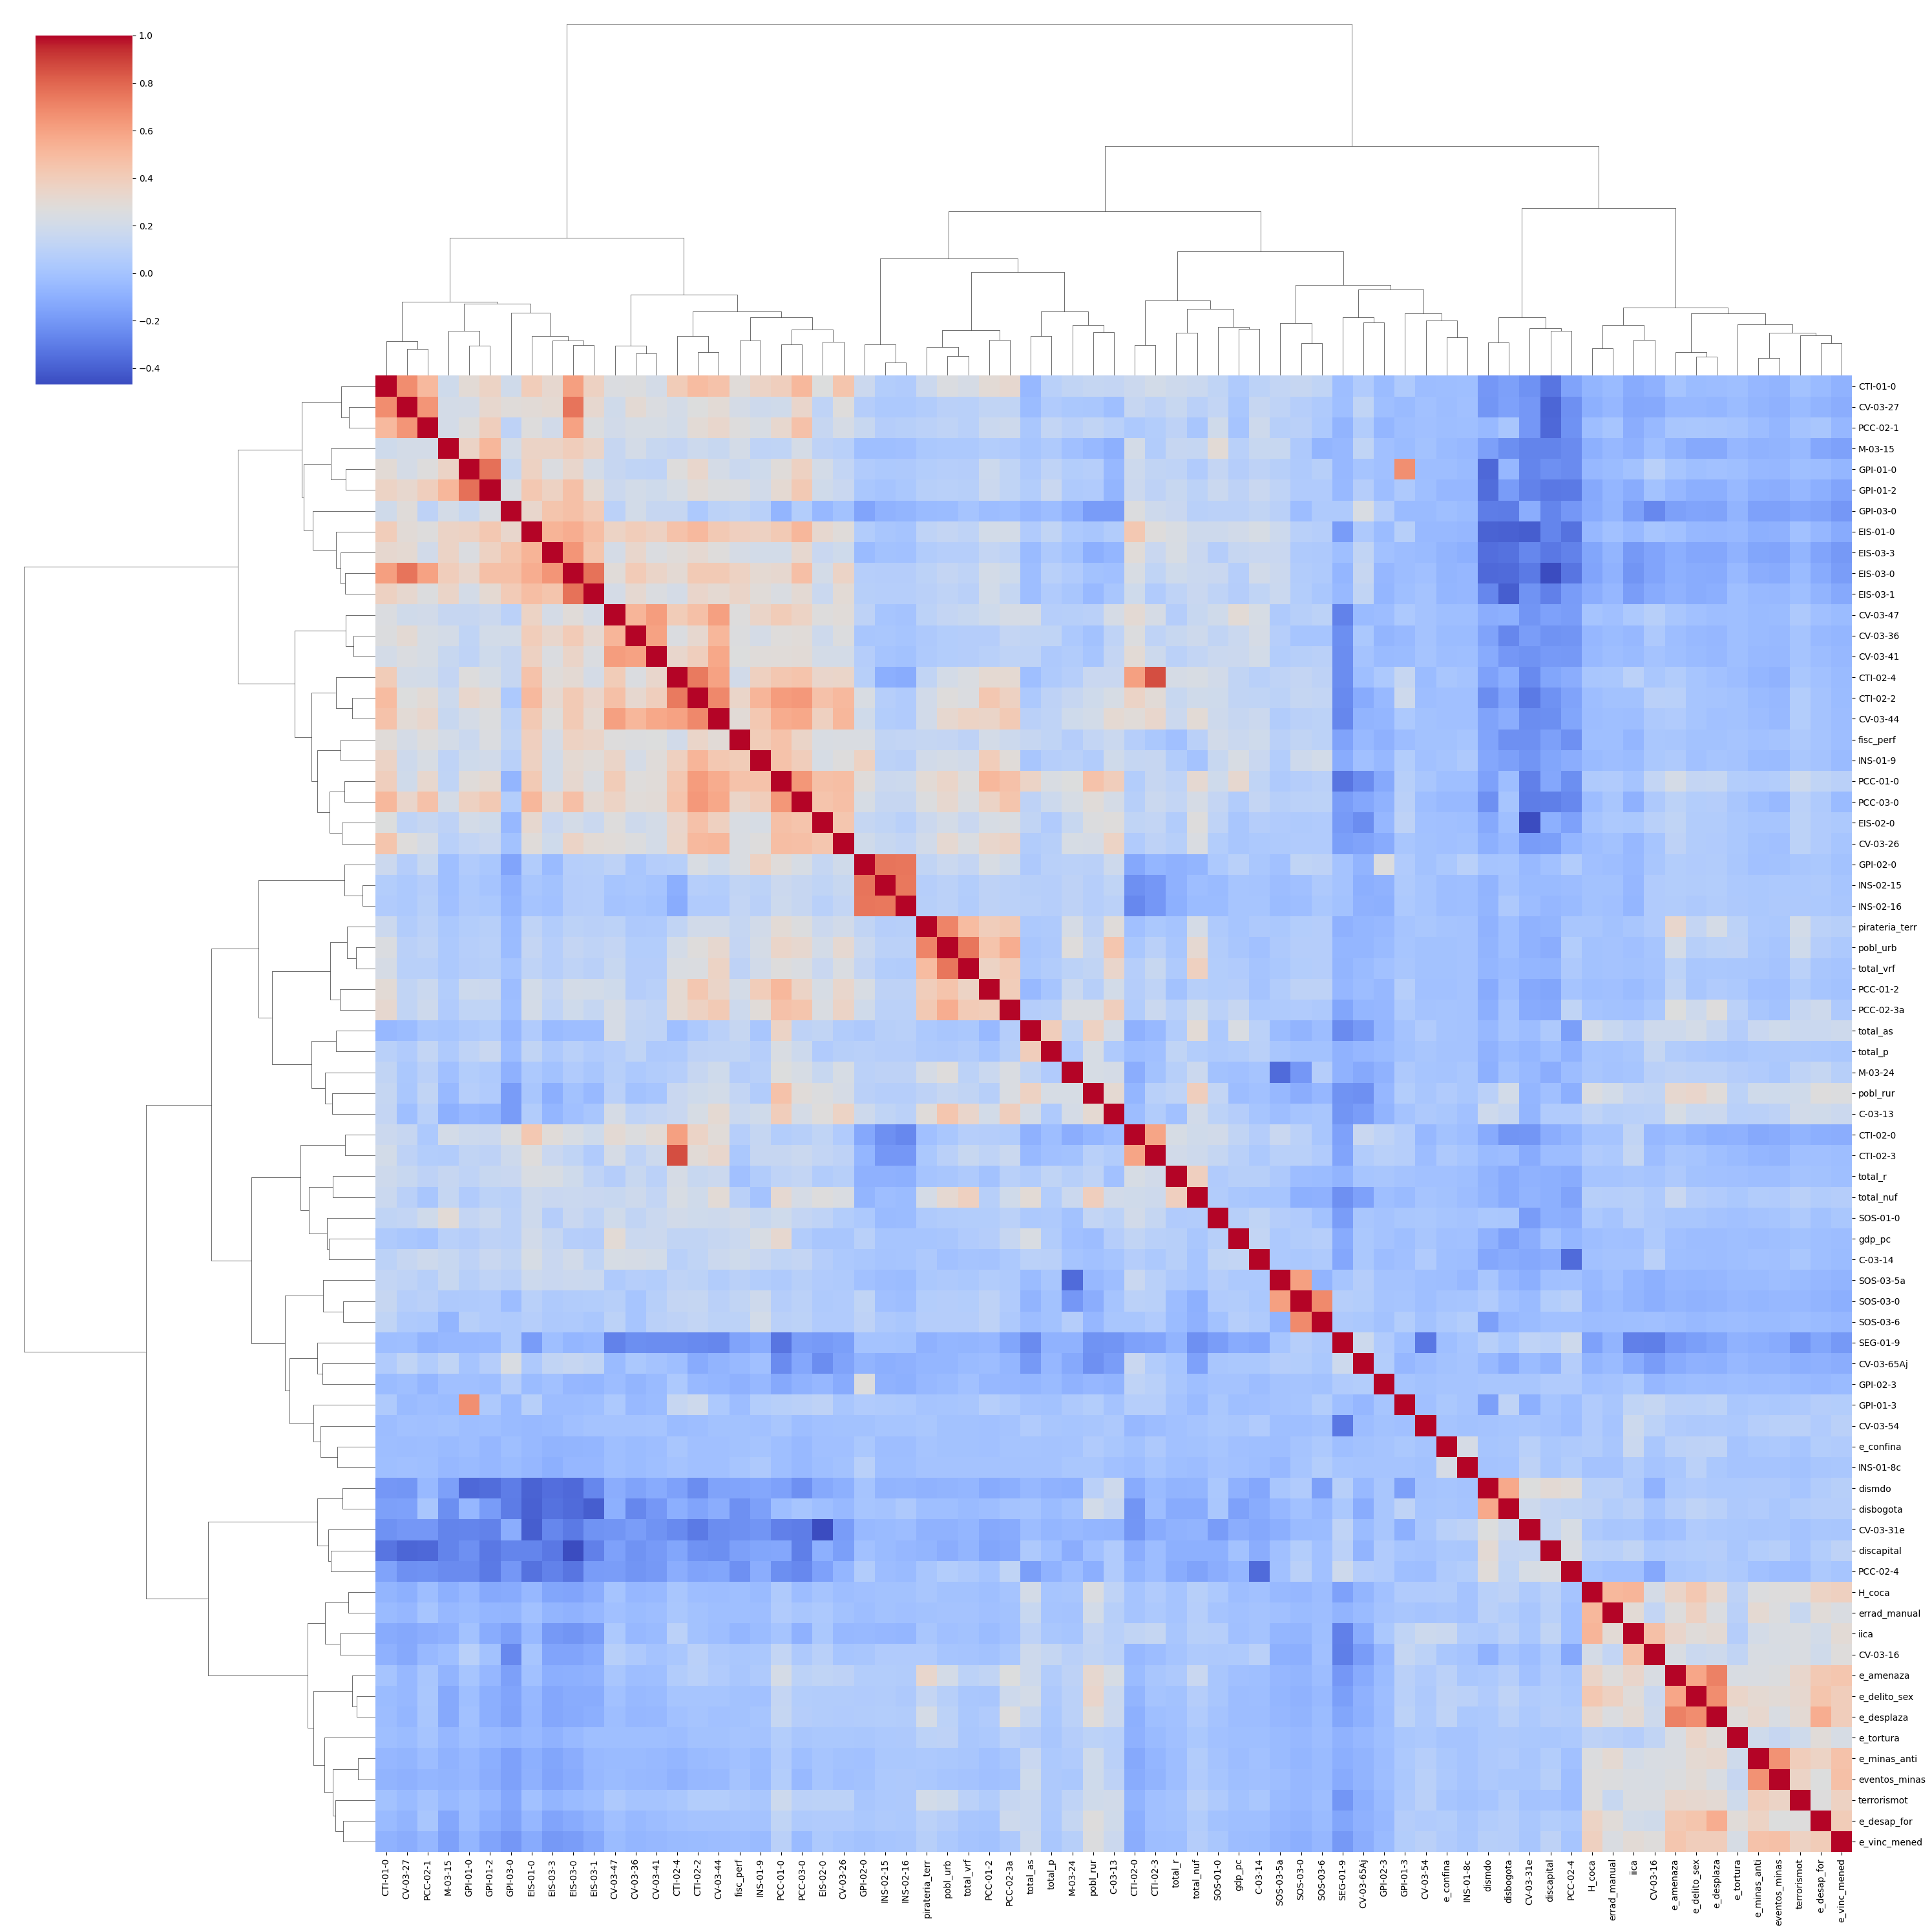

In [6]:
# y 
y = final_df['pc_loss']
y = np.log1p(final_df['pc_loss'])

# Normalize output
scaler = StandardScaler()
# y = scaler.fit_transform(y.values.reshape(-1, 1))

# X final
X1 = X1.drop(columns=['CV-01-15','CV-03-64', 'CV-03-26b', 'CV-01-11', 'CV-01-1', 'PCC-02-0', 'PCC-02-3', 'EIS-00-0', 'PCC-00-0', 'CTI-00-0', 'C-02-8t', 'ICM-00-0',
                      'EIS-03-4', 'CTI-01-3', 'SEG-00-0', 'SEG-01-6', 'SOS-00-0', 'SOS-02-0', 'SOS-02-2', 'SOS-01-6', 'GPI-00-0', 'GPI-02-4', 'GPI-02-5', 'P-01-34-1',
                      'P-01-46', 'P-01-25', 'CV-02-12e', 'CV-03-51', 'total_ac']) 
print(len(X1.columns))
# Keep feature names
original_feature_names = list(X1.columns) 

# Plot the new correlation matrix
corr_matrix = X1.corr()
sns.clustermap(corr_matrix, 
               method='ward',  # or 'complete', 'average'
               cmap='coolwarm',
               figsize=(30, 30))
plt.show()

In [10]:
# 🔹 Set Device for XGBoost (CPU or GPU)
from sklearn.metrics import mean_absolute_error


device = "cuda" if torch.cuda.is_available() else "cpu"

# Set seed for reproducibility
seed_value = 17
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)  # If using GPU

# 🔹 Define XGBoost Model Parameters
xgb_params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "max_depth": 6,
    "learning_rate": 0.05,
    "n_estimators": 1000,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "alpha": 0.01,  # L1 Regularization
    "lambda": 0.1,  # L2 Regularization
    "device": "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available
}

# 🔹 Define Time Series Split (5 Splits)
panel_split = PanelSplit(periods=final_df.year, n_splits=5)

# 🔹 Store Results for Cross-Validation
cv_results = []

for train_idx, test_idx in panel_split.split(X1):
    # Split dataset into Train & Test
    X_train, X_test = X1[train_idx], X1[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # 🔹 Train XGBoost Model
    xgb_model = xgb.XGBRegressor(**xgb_params, early_stopping_rounds=50)
    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )

    # 🔹 Get Predictions
    y_train_pred = xgb_model.predict(X_train)
    y_test_pred = xgb_model.predict(X_test)

    # 🔹 Compute Performance Metrics
    mse = mean_squared_error(y_test, y_test_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred)

    # 🔹 Store Results
    cv_results.append({"MSE": mse, "RMSE": rmse, "MAE": mae, "R2_train": r2_train, "R2_test": r2_test})

# 🔹 Compute Averages Across CV Splits
avg_results = {metric: np.mean([fold[metric] for fold in cv_results]) for metric in cv_results[0].keys()}

# 🔹 Print Results
print(f"✅ XGBoost with PanelSplit Results:")
print(f"📊 Avg MSE: {avg_results['MSE']:.4f}")
print(f"📊 Avg RMSE: {avg_results['RMSE']:.4f}")
print(f"📊 Avg MAE: {avg_results['MAE']:.4f}")
print(f"📊 Avg R² (Train): {avg_results['R2_train']:.4f}")
print(f"📊 Avg R² (Test): {avg_results['R2_test']:.4f}")

✅ XGBoost with PanelSplit Results:
📊 Avg MSE: 0.0041
📊 Avg RMSE: 0.0635
📊 Avg MAE: 0.0332
📊 Avg R² (Train): 0.9570
📊 Avg R² (Test): 0.6674


In [11]:
# Set seed for reproducibility
seed_value = 17
np.random.seed(seed_value)

# 🔹 Define XGBoost Model Parameters Grid
param_dist = {
    "max_depth": [4, 6, 8],  
    "learning_rate": [0.01, 0.05, 0.1],  
    "n_estimators": [500, 750, 1000],  
    "subsample": [0.7, 0.8, 0.9],  
    "colsample_bytree": [0.7, 0.8, 0.9],  
    "alpha": [0, 0.01, 0.1, 1],  # 🔹 L1 Regularization  
    "lambda": [0, 0.1, 1, 10],   # 🔹 L2 Regularization
}

# 🔹 Define Time Series Split (5 Splits)
panel_split = PanelSplit(periods=final_df.year, n_splits=5)

# 🔹 Store All Results
cv_results = []
saved_models = []

# Compute total iterations across all folds
total_iters = 100 * panel_split.n_splits

# 🔹 Prepare Randomized Parameter Search
param_list = list(ParameterSampler(param_dist, n_iter=100, random_state=seed_value))

# # Global progress bar across parameter sets
with tqdm(total=len(param_list), desc="🔍 Searching Hyperparameters (Cross-Validated)") as pbar:
    for i, params in enumerate(param_list):
        fold_metrics = []
        fold_models = []

        for fold, (train_idx, test_idx) in enumerate(panel_split.split(X1)):
            # Train-test split
            X_train, X_test = X1[train_idx], X1[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Define and train model
            xgb_model = xgb.XGBRegressor(
                **params,
                objective="reg:squarederror",
                eval_metric="rmse",
                early_stopping_rounds=50,
                random_state=seed_value,
                device="cuda" if torch.cuda.is_available() else "cpu"
            )

            xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

            # Predict
            y_test_pred = xgb_model.predict(X_test)
            y_train_pred = xgb_model.predict(X_train)

            # Store metrics
            mse = mean_squared_error(y_test, y_test_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, y_test_pred)
            r2_test = r2_score(y_test, y_test_pred)
            r2_train = r2_score(y_train, y_train_pred)

            fold_metrics.append({
                "MSE": mse,
                "RMSE": rmse,
                "MAE": mae,
                "R2_test": r2_test,
                "R2_train": r2_train
            })
            fold_models.append(xgb_model)

        # Average across folds
        avg_metrics = {
            "MSE": np.mean([m["MSE"] for m in fold_metrics]),
            "RMSE": np.mean([m["RMSE"] for m in fold_metrics]),
            "MAE": np.mean([m["MAE"] for m in fold_metrics]),
            "R2_test": np.mean([m["R2_test"] for m in fold_metrics]),
            "R2_train": np.mean([m["R2_train"] for m in fold_metrics])
        }

        saved_models.append({
            "params": params,
            "metrics": avg_metrics,
            "models": fold_models  # or just best_model = fold_models[np.argmax(...)]
        })
        pbar.update(1)


🔍 Searching Hyperparameters (Cross-Validated): 100%|██████████| 100/100 [29:36<00:00, 17.76s/it]


In [12]:
# 🔹 Find Best Model Across All Folds
best_model = min(saved_models, key=lambda x: (x['metrics']["RMSE"]))


print(f"✅ Best Overall Parameters: {best_model['params']}")
print(f"📊 Best Overall MSE: {best_model['metrics']['MSE']:.4f}")
print(f"📊 Best Overall MAE: {best_model['metrics']['MAE']:.4f}")
print(f"📊 Best Overall RMSE: {best_model['metrics']['RMSE']:.4f}")
print(f"📊 Best R² (Train): {best_model['metrics']['R2_train']:.4f}")
print(f"📊 Best R² (Test): {best_model['metrics']['R2_test']:.4f}")

✅ Best Overall Parameters: {'subsample': 0.9, 'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.05, 'lambda': 10, 'colsample_bytree': 0.8, 'alpha': 1}
📊 Best Overall MSE: 0.0038
📊 Best Overall MAE: 0.0302
📊 Best Overall RMSE: 0.0604
📊 Best R² (Train): 0.9462
📊 Best R² (Test): 0.6981


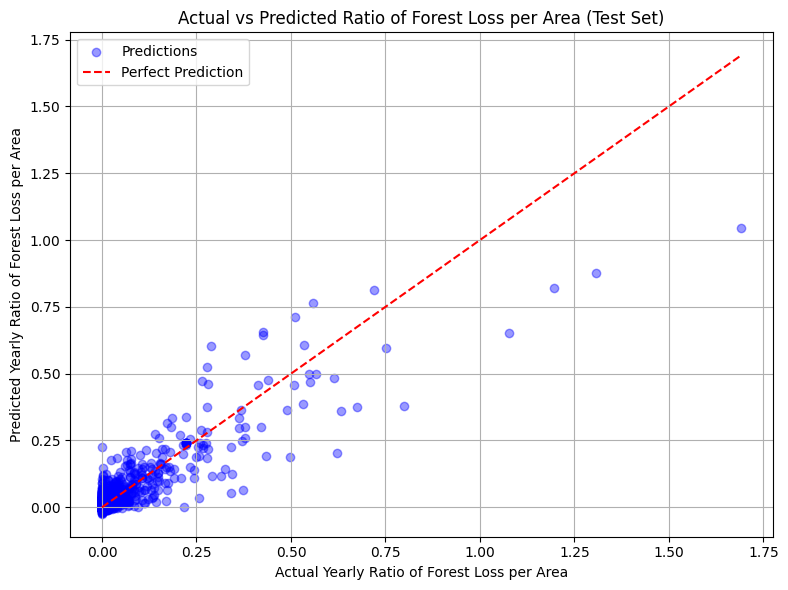

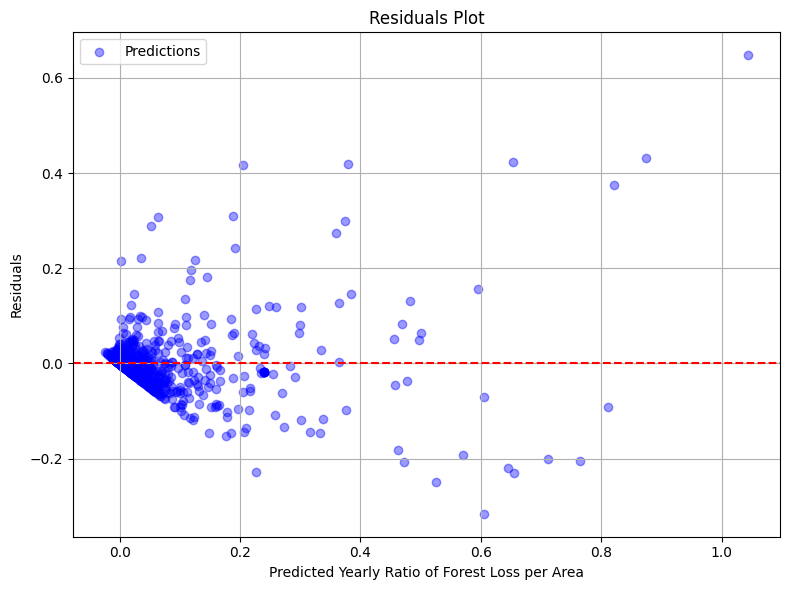

In [13]:
best_params = best_model["params"]

# Re-train on all available data
final_model = xgb.XGBRegressor(
    **best_params,
    objective="reg:squarederror",
    eval_metric="rmse",
    device="cuda" if torch.cuda.is_available() else "cpu"
)

# Use your final trained model
final_model.fit(X_train, y_train)  # Re-train on training data since we will compare against the test set from last fold   
y_test_pred = final_model.predict(X_test)  # From your final fold
y_test_pred = np.expm1(y_test_pred)  # Inverse transform if you used log1p
y_true = y_test  # actual values
y_true = np.expm1(y_true)  # Inverse transform if you used log1p


# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_test_pred, alpha=0.4, color='blue', label='Predictions')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Perfect Prediction')

plt.xlabel("Actual Yearly Ratio of Forest Loss per Area")
plt.ylabel("Predicted Yearly Ratio of Forest Loss per Area")
plt.title("Actual vs Predicted Ratio of Forest Loss per Area (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Residuals plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_pred, y_true - y_test_pred, alpha=0.4, color='blue', label='Predictions')
plt.axhline(y=0, color='r', linestyle='--')

plt.xlabel("Predicted Yearly Ratio of Forest Loss per Area")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
shap_values_top10

.values =
array([[-0.00088815,  0.00554192, -0.00282053, ..., -0.01031325,
         0.01256202, -0.00907715],
       [-0.00129315,  0.00504897, -0.00255677, ..., -0.00979748,
         0.01489581, -0.00912971],
       [ 0.00216285,  0.00479596, -0.00364588, ..., -0.00898506,
         0.01020193, -0.00947683],
       ...,
       [ 0.00439482, -0.01222574, -0.00144206, ...,  0.01341351,
        -0.01500182,  0.07440051],
       [ 0.00964182, -0.00906432,  0.00525209, ...,  0.01576087,
        -0.01719438,  0.05227527],
       [ 0.01078069, -0.00810356,  0.00467112, ...,  0.01324158,
        -0.02016051,  0.07533211]], dtype=float32)

.base_values =
array([0.05657039, 0.05657039, 0.05657039, ..., 0.05657039, 0.05657039,
       0.05657039], dtype=float32)

.data =
array([[5.53531822e+01, 0.00000000e+00, 2.30944600e+06, ...,
        4.51655486e+01, 2.64000000e+02, 0.00000000e+00],
       [5.32054914e+01, 0.00000000e+00, 2.33556800e+06, ...,
        4.52458798e+01, 2.64000000e+02, 0.00000000e

Text(0.5, 1.0, 'XGBoost - mena absolut SHAP values (Top 10 Features)')

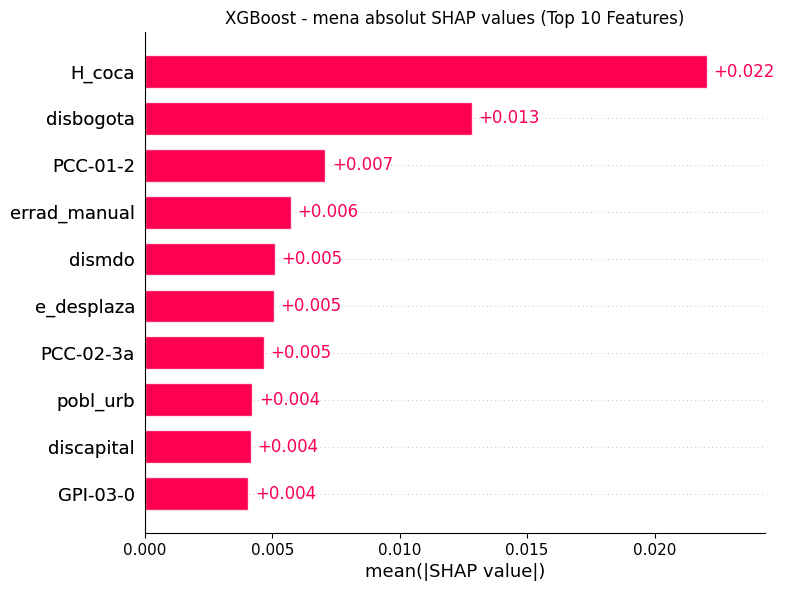

In [33]:
# 🔹 Compute SHAP Values for Feature Importance
explainer = shap.Explainer(final_model)
shap_values = explainer(X_train)

# Compute mean absolute SHAP values for each feature
shap_abs_mean = np.abs(shap_values.values).mean(axis=0)

# Get indices of the top 10 features
top_10_indices = np.argsort(shap_abs_mean)[-10:]
top_10_indices

# Filter SHAP values to keep only the top 10 features
shap_values_top10 = shap.Explanation(
    values=shap_values.values[:, top_10_indices],  # Keep only top 10 values
    base_values=shap_values.base_values,  # Keep base values
    data=shap_values.data[:, top_10_indices],  # Keep only top 10 feature data
    feature_names=[original_feature_names[i] for i in top_10_indices]  # Correct feature names
)


# Plot the bar chart without "other features"
shap.plots.bar(shap_values_top10, show=False)
plt.title("XGBoost - mena absolut SHAP values (Top 10 Features)")
# “The absolute contribution of coca crops to the model’s predictions corresponds to an average shift of about 0.02 on the log(1 + yearly forest loss per capita) scale, 
# which translates to roughly a 2% multiplicative effect on (1 + yearly forest loss per capita).”


Text(0.5, 1.0, 'XGBoost - mena absolut SHAP values (Top 10 Features)')

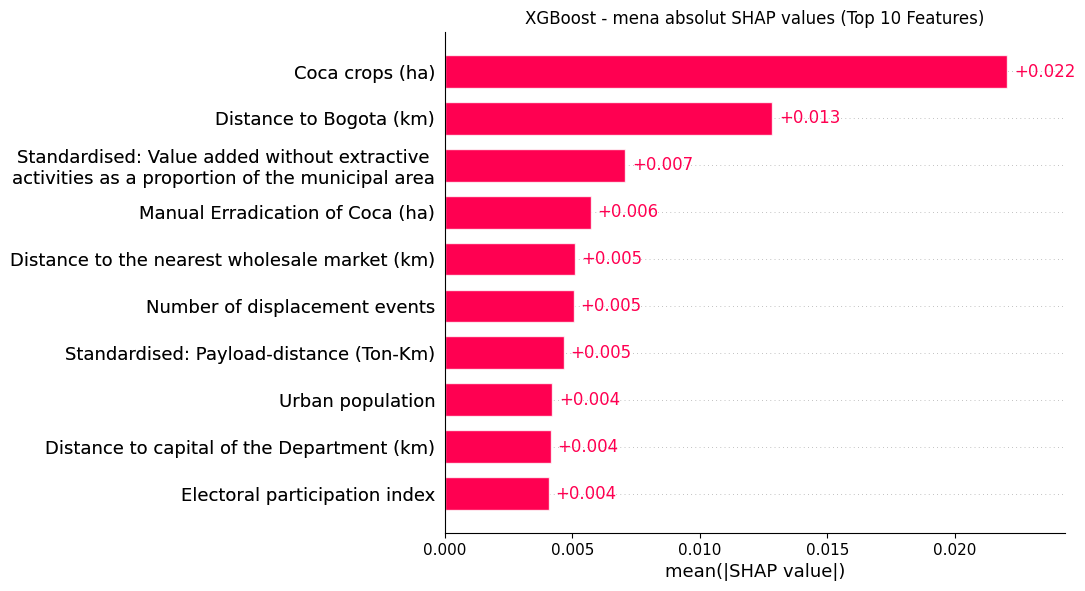

In [35]:
# 🔹 Compute SHAP Values for Feature Importance
explainer = shap.Explainer(final_model)
shap_values = explainer(X_train)

# Compute mean absolute SHAP values for each feature
shap_abs_mean = np.abs(shap_values.values).mean(axis=0)

# Fixed names
custom_feature_names = [
    "Coca crops (ha)", "Distance to Bogota (km)", "Standardised: Value added without extractive \nactivities as a proportion of the municipal area", "Manual Erradication of Coca (ha)", 
    "Distance to the nearest wholesale market (km)", "Number of displacement events", "Standardised: Payload-distance (Ton-Km)", "Urban population", "Distance to capital of the Department (km)", 
    "Electoral participation Index"
]
custom_feature_names = [custom_feature_names[i] for i in range(len(custom_feature_names)-1, -1, -1)]


# Filter SHAP values to keep only the top 10 features
shap_values_top10 = shap.Explanation(
    values=shap_values.values[:, top_10_indices],  # Keep only top 10 values
    base_values=shap_values.base_values,  # Keep base values
    data=shap_values.data[:, top_10_indices],  # Keep only top 10 feature data
    feature_names=custom_feature_names  # Correct feature names
)


# Plot the bar chart without "other features"
shap.plots.bar(shap_values_top10, show=False)
plt.title("XGBoost - mena absolut SHAP values (Top 10 Features)")
# “The absolute contribution of coca crops to the model’s predictions corresponds to an average shift of about 0.02 on the log(1 + yearly forest loss per capita) scale, 
# which translates to roughly a 2% multiplicative effect on (1 + yearly forest loss per capita).”


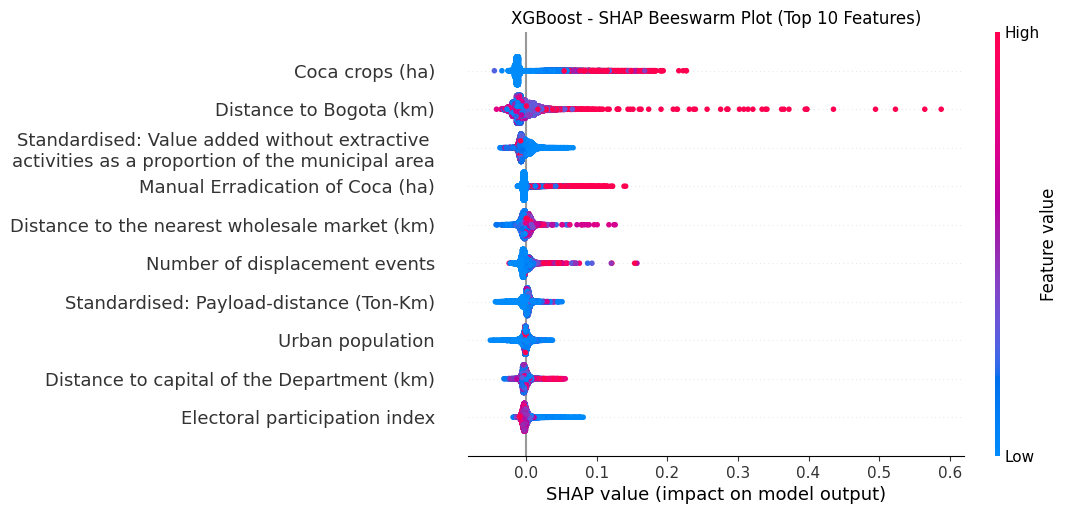

In [36]:
plt.figure(figsize=(16, 10))  
shap.plots.beeswarm(shap_values_top10, show=False)
plt.title("XGBoost - SHAP Beeswarm Plot (Top 10 Features)")
plt.show()
# “For some observations with high values of H_coca, the model’s prediction of yearly forest loss per capita can be up to about 25% higher than the model’s baseline 
# prediction (once we convert the SHAP value from the log(1 + y) scale back to the original scale).”

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Convert SHAP Explanation to DataFrame
# Assume shap_values is the original explanation computed for X_train.
# Use the feature names provided by shap_values.
shap_df = pd.DataFrame(shap_values.values, columns=shap_values.feature_names, index=X_train.index)

# Merge with the cluster variable from your original dataset (final_df)
# Ensure that final_df and X_train have a common index or column to join on.
# For instance, if they share the same index:
shap_df = shap_df.merge(final_df[['cluster_kmeans']], left_index=True, right_index=True)

# Now, for each cluster, compute the mean absolute SHAP values per feature.
cluster_shap = shap_df.groupby('cluster_kmeans').apply(lambda df: df.drop('cluster_kmeans', axis=1).abs().mean())

# Adding correct labels to the variables
rename_dict = {
    # "old_name": "New Descriptive Name"
    "H_coca": "Coca crops (ha)",
    "disbogota": "Distance to Bogota (km)",
    "PCC-01-2": "Standardised: Value added without \nextractive activities (%)",
    "errad_manual": "Manual Eradication of Coca (ha)",
    "dismdo": "Distance to the nearest wholesale market (km)",
    "PCC-02-3a": "Standardised: Payload-distance (Ton-Km)",
    "pobl_urb": "Urban population",
    "discapital": "Distance to capital of the Department (km)",
    "GPI-03-0": "Electoral participation Index",
    "e_desplaza": "Number of displacement events",
    "eventos_minas": "Number of anti-personnel mine events",
    "total_vrf": "Total value of agricultural credits (COP)",
    "INS-01-8c": "Collection of the Unified Property Tax, \nconstant (COP)",
    "CV-03-16": "Homicide rate per 100,000 inhabitants",
    "CTI-02-3": "Standardised: Broadband downstream speed (Mbps)",
    "CTI-02-0": "Technology Index"
}


C:\Users\cpedr\AppData\Local\Temp\ipykernel_70652\688145827.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_shap = shap_df.groupby('cluster_kmeans').apply(lambda df: df.drop('cluster_kmeans', axis=1).abs().mean())


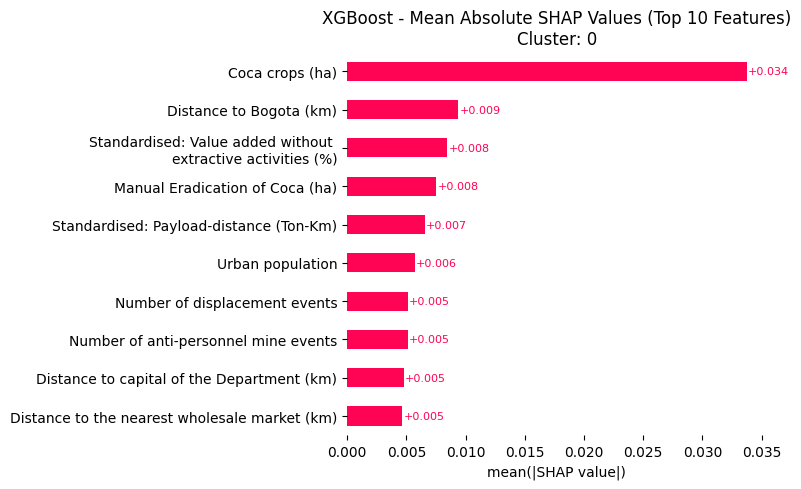

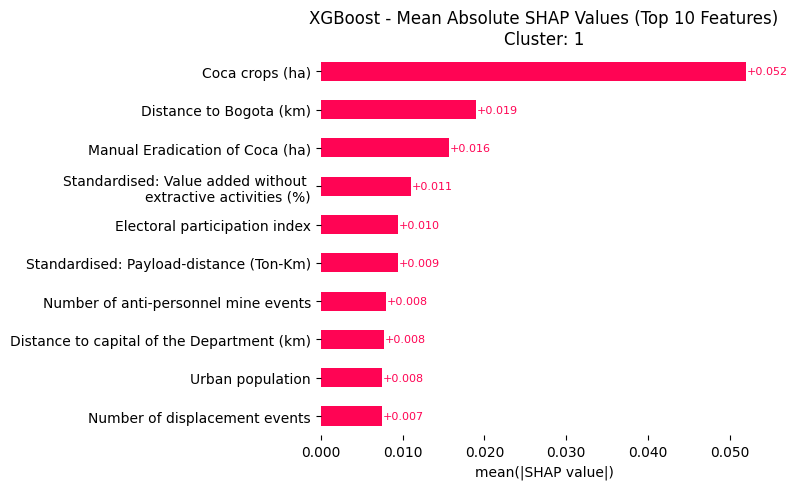

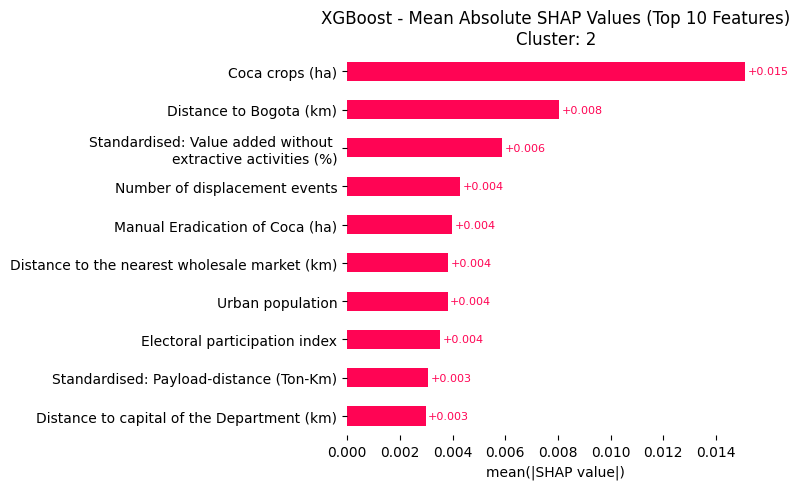

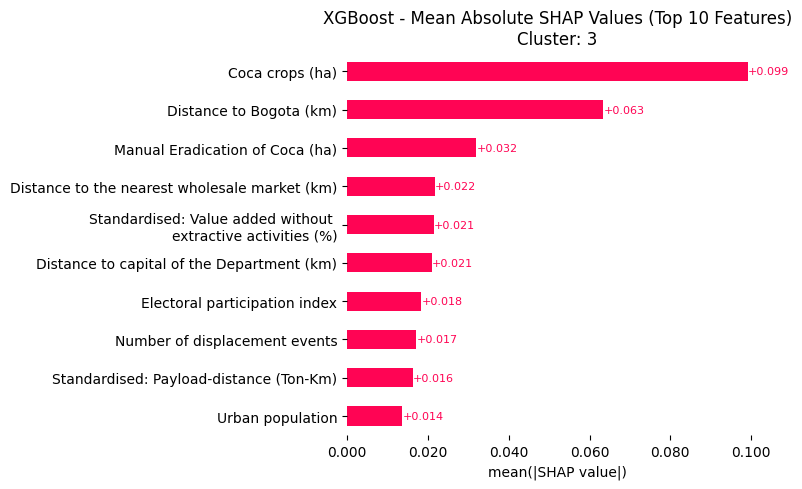

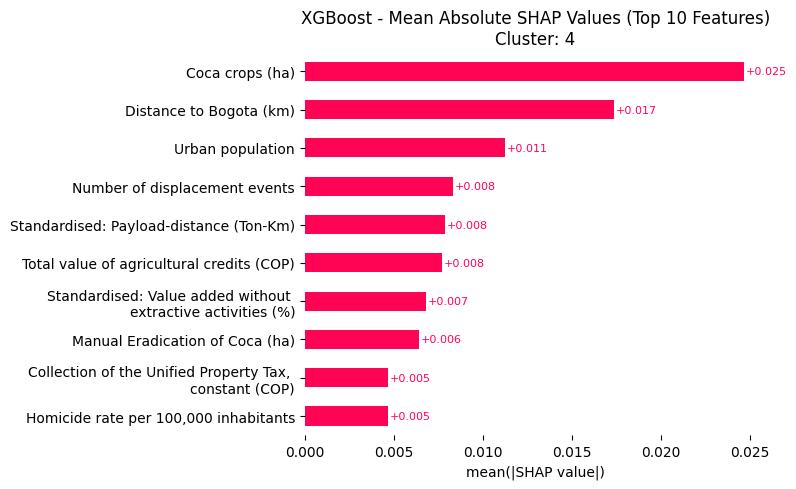

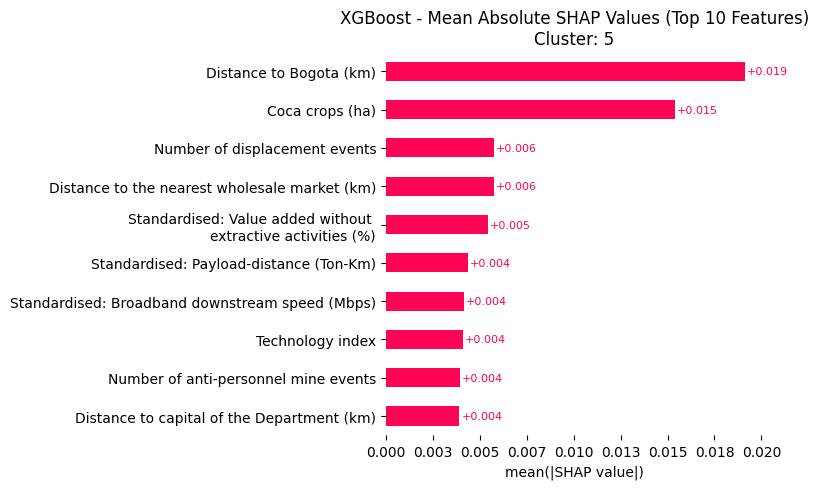

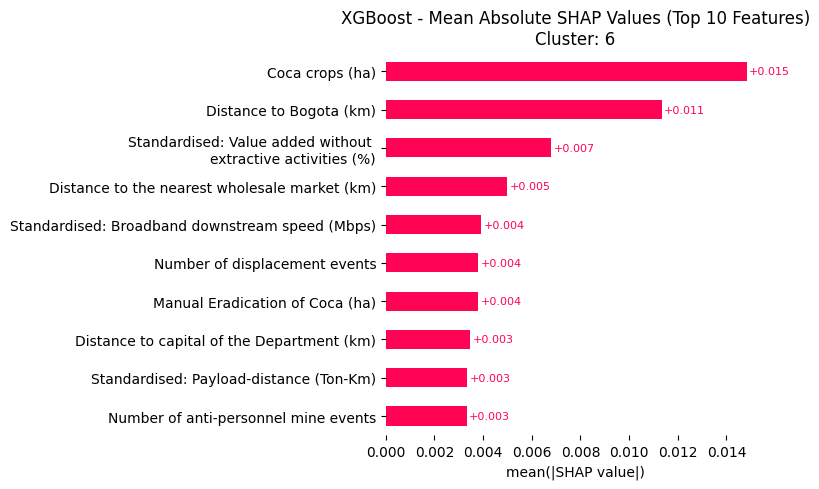

In [48]:
from turtle import color
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FormatStrFormatter

for cluster_label in cluster_shap.index:
    # 1. Extract the row for this cluster
    cluster_values = cluster_shap.loc[cluster_label]
    
    # 2. Sort descending and pick top 10
    top_10 = cluster_values.sort_values(ascending=False).head(10)
    
    # 3. Rename features
    top_10_renamed = top_10.rename(index=rename_dict)
    
    # 4. Sort ascending for a nice barh layout (smallest at the bottom)
    sorted_top_10_renamed = top_10_renamed.sort_values(ascending=True)
    
    # 5. Create a new figure and axis
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # 6. Plot a horizontal bar chart
    sorted_top_10_renamed.plot(
        kind='barh', 
        color='#ff0454',
        edgecolor='none',   # No border on the bars
        ax=ax
    )
    
    # 7. Remove the chart frame (spines)
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    
    # 9. Label each bar with its value
    #    We'll place the text a small offset to the right of the bar
    for i, (feature_name, shap_val) in enumerate(sorted_top_10_renamed.items()):
        # y-coordinate is i, x-coordinate is shap_val
        ax.text(shap_val + 0.0001, i, f"+{shap_val:.3f}", va='center', fontsize=8, color='#ff0454')
    
    # 10. Format the x-axis to show 3 decimal places
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    # 11. Title and labels
    ax.set_title(f"XGBoost - Mean Absolute SHAP Values (Top 10 Features)\nCluster: {cluster_label}")
    ax.set_xlabel("mean(|SHAP value|)")
    ax.set_ylabel("")  # Typically the feature names appear automatically on the y-axis
    
    plt.tight_layout()
    plt.show()


C:\Users\cpedr\AppData\Local\Temp\ipykernel_70652\2084523400.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  region_shap = shap_df.groupby('Region').apply(lambda df: df.drop('Region', axis=1).abs().mean())


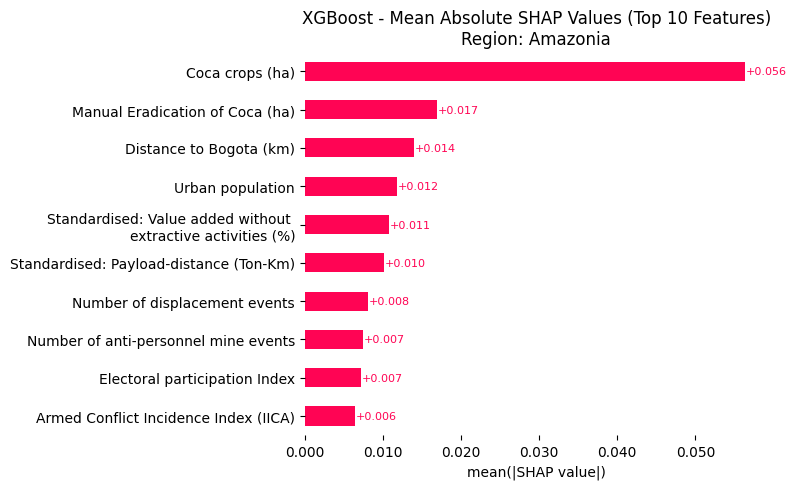

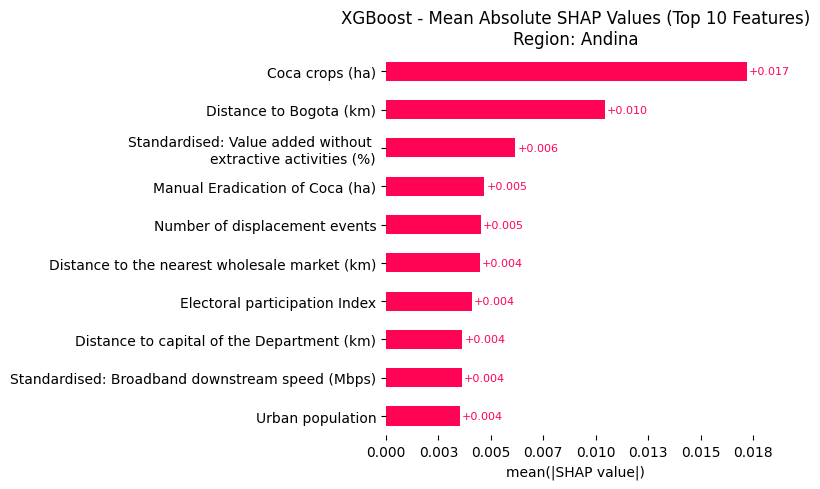

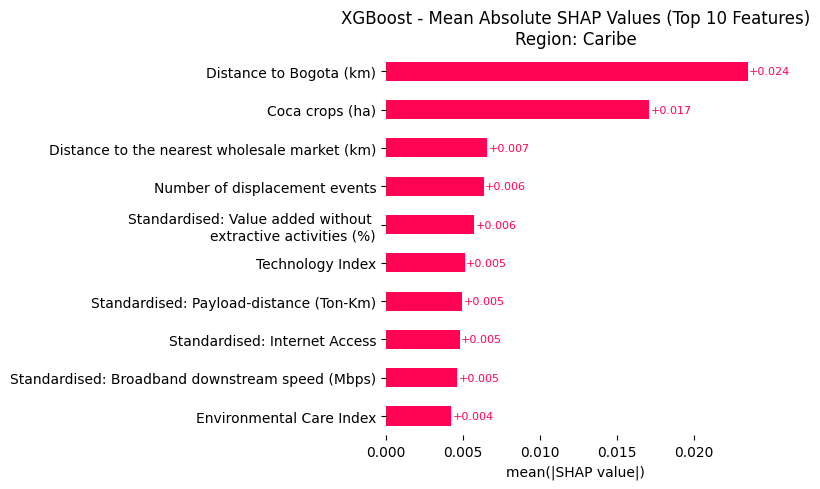

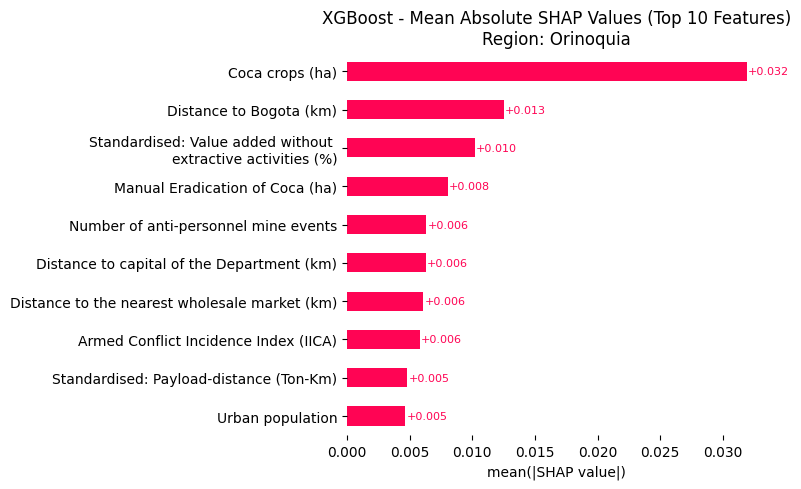

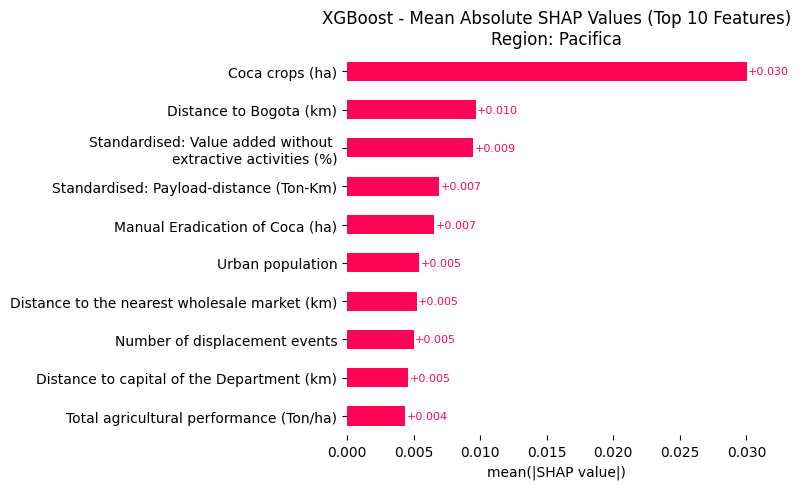

In [61]:
# Merge with the cluster variable from your original dataset (final_df)
# Ensure that final_df and X_train have a common index or column to join on.
# For instance, if they share the same index:
shap_df = pd.DataFrame(shap_values.values, columns=shap_values.feature_names, index=X_train.index)
shap_df = shap_df.merge(final_df[['Region']], left_index=True, right_index=True)

# Now, for each cluster, compute the mean absolute SHAP values per feature.
region_shap = shap_df.groupby('Region').apply(lambda df: df.drop('Region', axis=1).abs().mean())

# Adding correct labels to the variables
rename_dict = {
    # "old_name": "New Descriptive Name"
    "H_coca": "Coca crops (ha)",
    "disbogota": "Distance to Bogota (km)",
    "PCC-01-2": "Standardised: Value added without \nextractive activities (%)",
    "errad_manual": "Manual Eradication of Coca (ha)",
    "dismdo": "Distance to the nearest wholesale market (km)",
    "PCC-02-3a": "Standardised: Payload-distance (Ton-Km)",
    "pobl_urb": "Urban population",
    "discapital": "Distance to capital of the Department (km)",
    "GPI-03-0": "Electoral participation Index",
    "e_desplaza": "Number of displacement events",
    "eventos_minas": "Number of anti-personnel mine events",
    "total_vrf": "Total value of agricultural credits (COP)",
    "INS-01-8c": "Collection of the Unified Property Tax, \nconstant (COP)",
    "CV-03-16": "Homicide rate per 100,000 inhabitants",
    "CTI-02-3": "Standardised: Broadband downstream speed (Mbps)",
    "CTI-02-0": "Technology Index",
    "iica": "Armed Conflict Incidence Index (IICA)",
    "SOS-01-0": "Environmental Care Index",
    "CTI-02-4": "Standardised: Internet Access",
    "total_r": "Total agricultural performance (Ton/ha)"
}

for region_label in region_shap.index:
    # 1. Extract the row for this region
    region_values = region_shap.loc[region_label]
    
    # 2. Sort descending and pick top 10
    top_10 = region_values.sort_values(ascending=False).head(10)
    
    # 3. Rename features
    top_10_renamed = top_10.rename(index=rename_dict)
    
    # 4. Sort ascending for a nice barh layout (smallest at the bottom)
    sorted_top_10_renamed = top_10_renamed.sort_values(ascending=True)
    
    # 5. Create a new figure and axis
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # 6. Plot a horizontal bar chart
    sorted_top_10_renamed.plot(
        kind='barh', 
        color='#ff0454',
        edgecolor='none',   # No border on the bars
        ax=ax
    )
    
    # 7. Remove the chart frame (spines)
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    
    # 9. Label each bar with its value
    #    We'll place the text a small offset to the right of the bar
    for i, (feature_name, shap_val) in enumerate(sorted_top_10_renamed.items()):
        # y-coordinate is i, x-coordinate is shap_val
        ax.text(shap_val + 0.0001, i, f"+{shap_val:.3f}", va='center', fontsize=8, color='#ff0454')
    
    # 10. Format the x-axis to show 3 decimal places
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    # 11. Title and labels
    ax.set_title(f"XGBoost - Mean Absolute SHAP Values (Top 10 Features)\nRegion: {region_label}")
    ax.set_xlabel("mean(|SHAP value|)")
    ax.set_ylabel("")  # Typically the feature names appear automatically on the y-axis
    
    plt.tight_layout()
    plt.show()


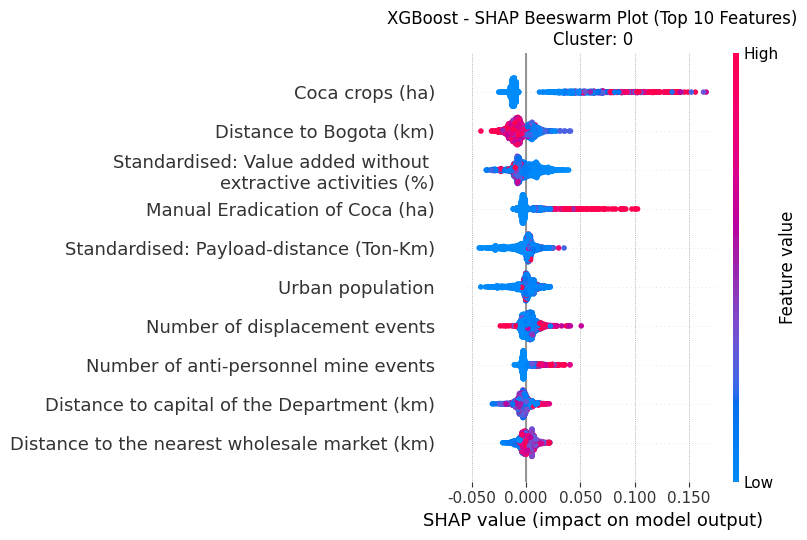

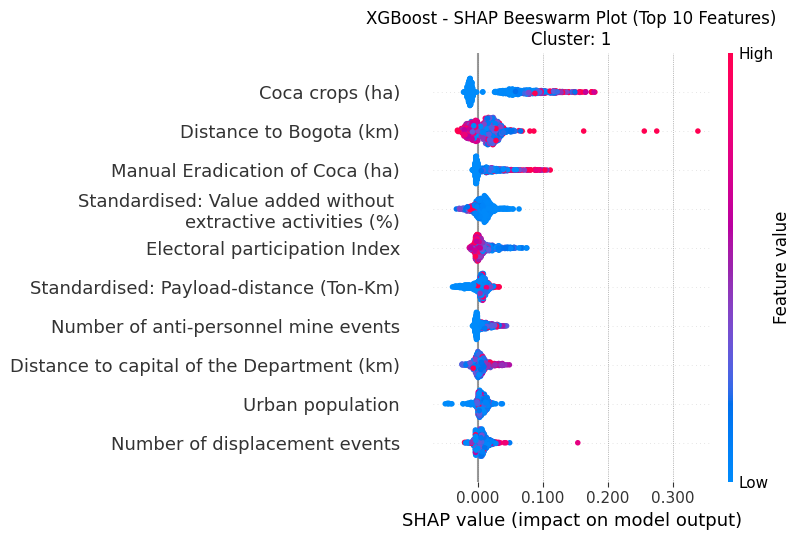

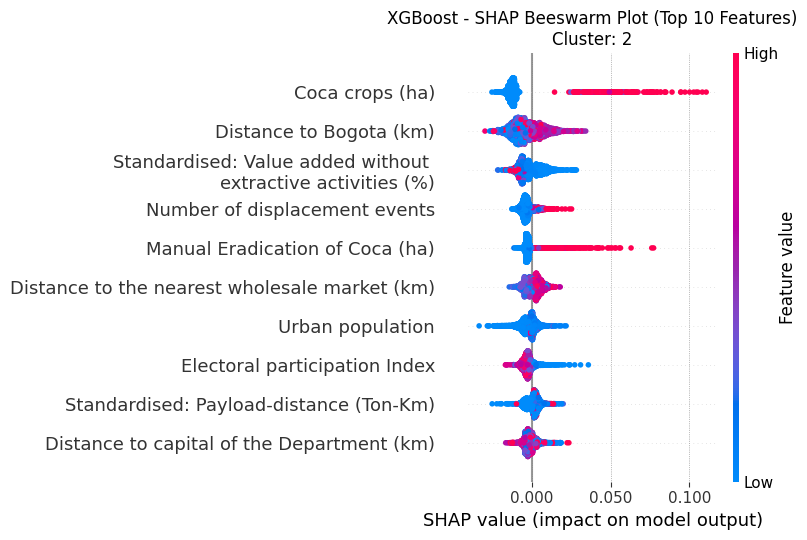

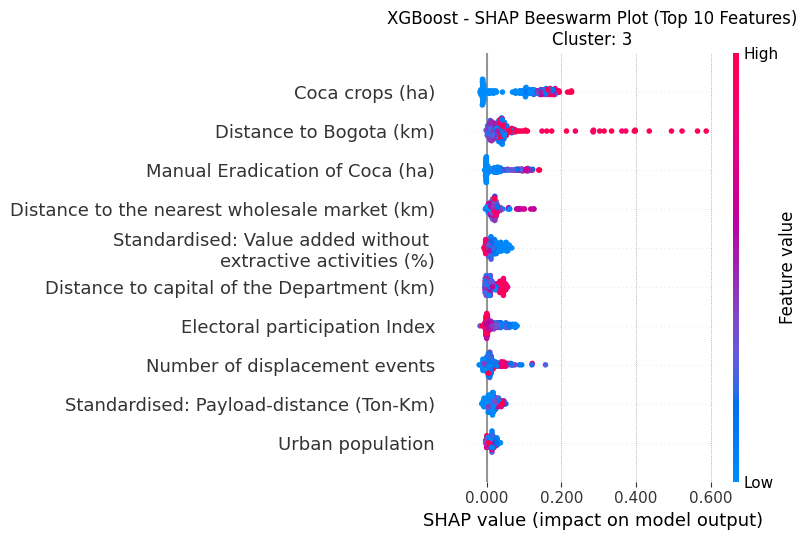

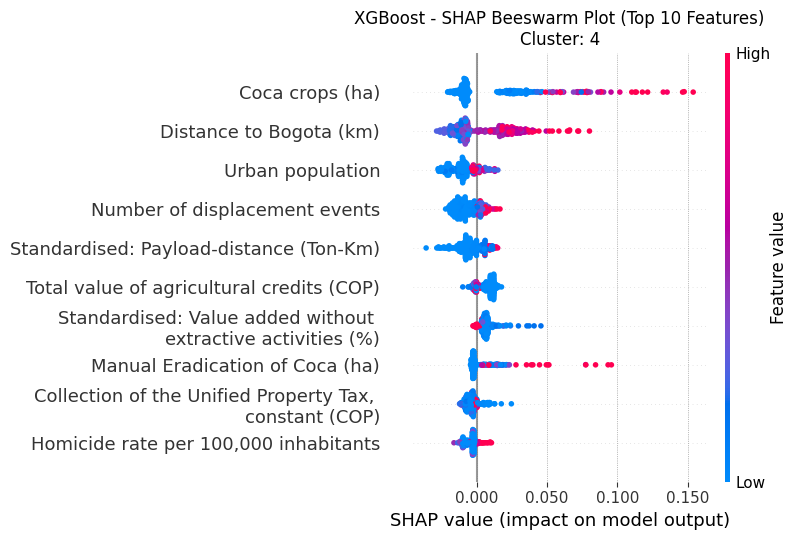

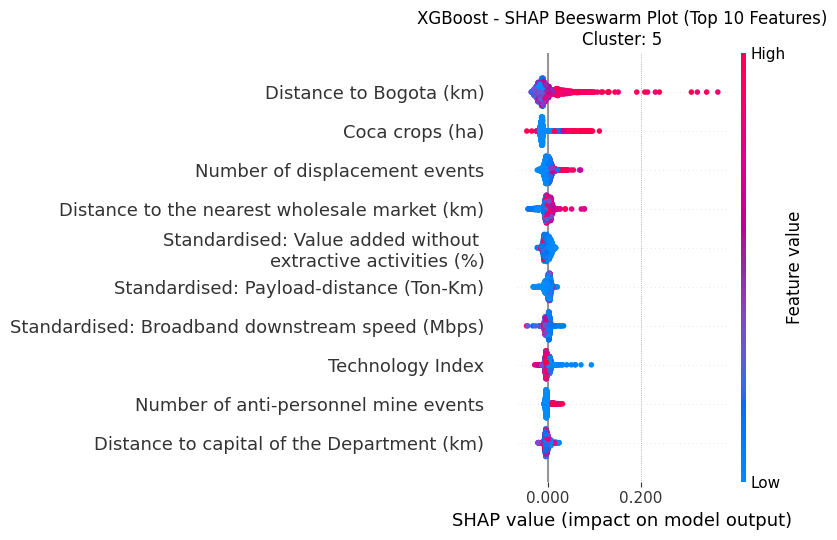

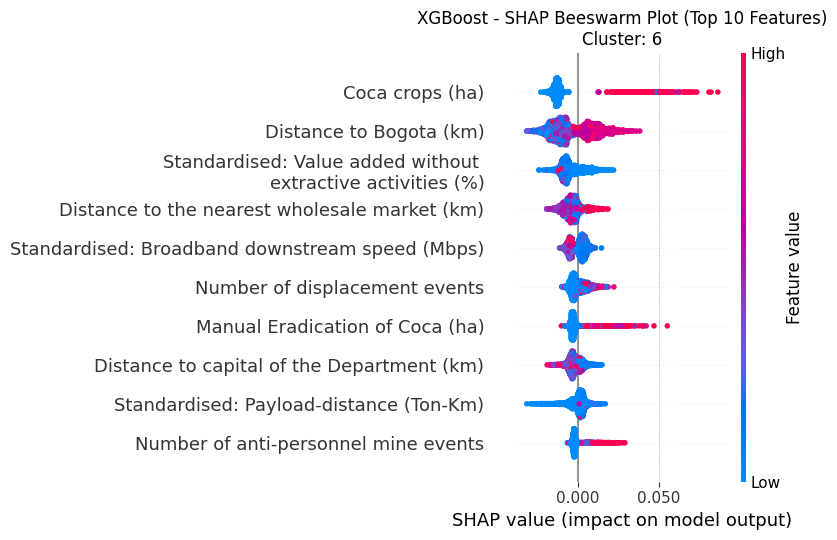

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# Loop through each unique cluster
for cluster_label in sorted(final_df['cluster_kmeans'].unique()):
    # Identify indices for the current cluster (make sure indices align between X_train and final_df)
    cluster_indices = final_df[final_df['cluster_kmeans'] == cluster_label].index
    mask = X_train.index.isin(cluster_indices)
    
    # Subset the SHAP explanation for this cluster
    shap_cluster = shap.Explanation(
        values=shap_values.values[mask],
        base_values=shap_values.base_values[mask],
        data=shap_values.data[mask],
        feature_names=shap_values.feature_names
    )
    
    # Convert to DataFrame to compute the mean absolute SHAP values per feature
    shap_cluster_df = pd.DataFrame(shap_cluster.values, columns=shap_cluster.feature_names)
    mean_abs = shap_cluster_df.abs().mean()
    
    # Get the top 10 features for the cluster (sorted in descending order)
    top10_features = mean_abs.sort_values(ascending=False).head(10).index
    
    # Determine the corresponding column indices for these top features
    top10_indices = [list(shap_cluster.feature_names).index(feat) for feat in top10_features]
    
    # Create a list of custom feature names using your rename dictionary; if a feature is not in the dict, keep its original name.
    custom_feature_names = [rename_dict.get(feat, feat) for feat in top10_features]
    
    # Create a new SHAP Explanation with only the top 10 features
    shap_values_top10 = shap.Explanation(
        values=shap_cluster.values[:, top10_indices],
        base_values=shap_cluster.base_values,
        data=shap_cluster.data[:, top10_indices],
        feature_names=custom_feature_names
    )
    
    # Create a figure for the beeswarm plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot the beeswarm plot using the subset SHAP Explanation
    shap.plots.beeswarm(shap_values_top10, show=False)
    
    # Customizations: Remove spines and add dotted grid lines along x-axis
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(axis='x', color='gray', linestyle=':', linewidth=0.5)
    
    # Format x-axis tick labels to show up to 3 decimal places
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    # Set title and layout
    plt.title(f"XGBoost - SHAP Beeswarm Plot (Top 10 Features)\nCluster: {cluster_label}")
    plt.tight_layout()
    plt.show()


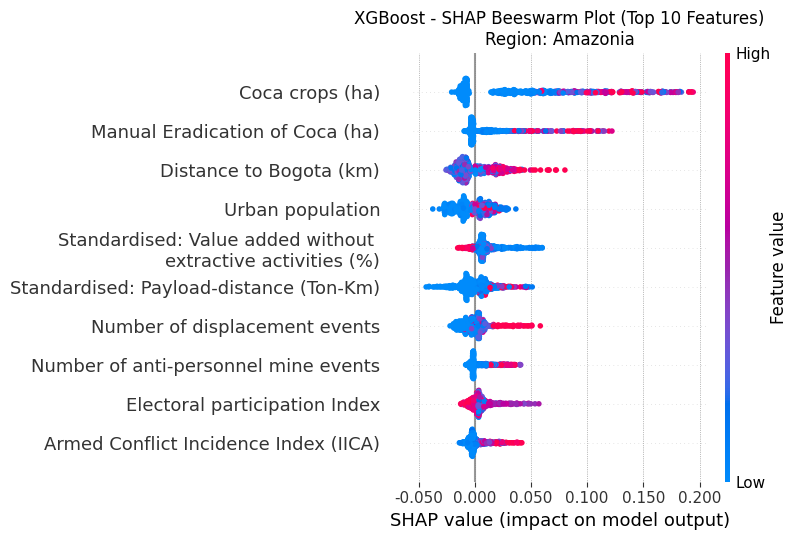

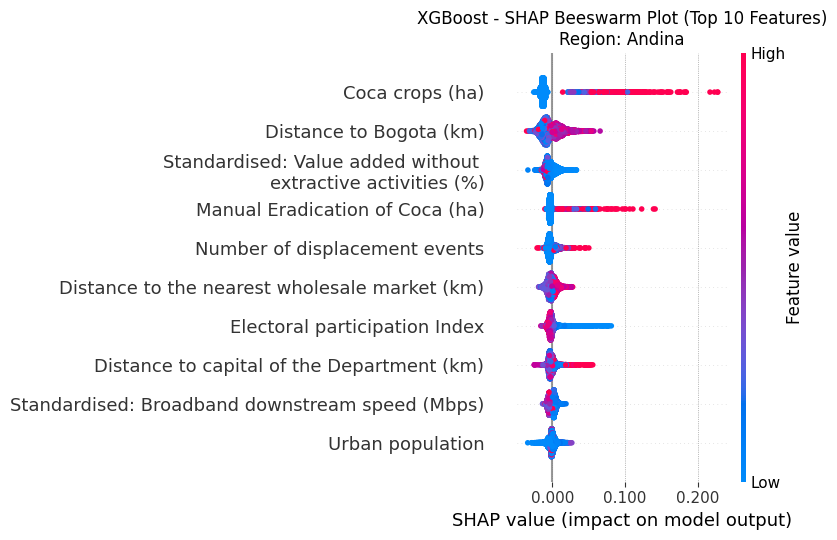

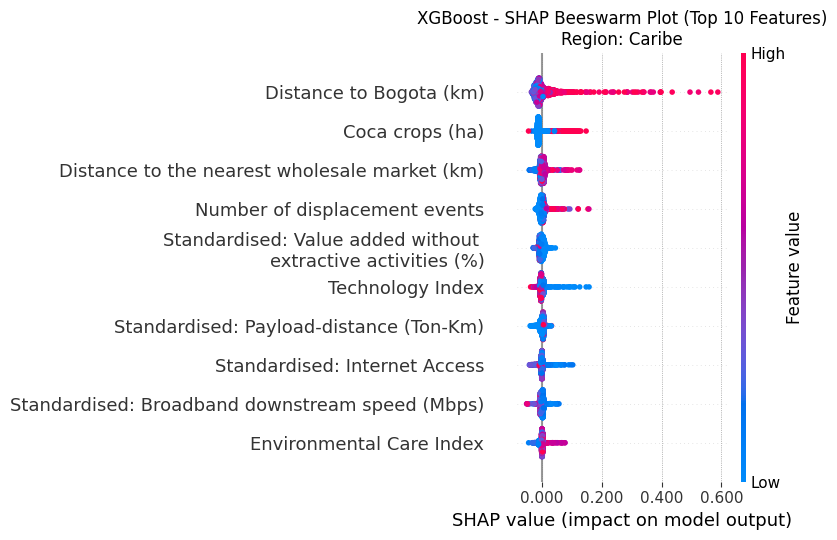

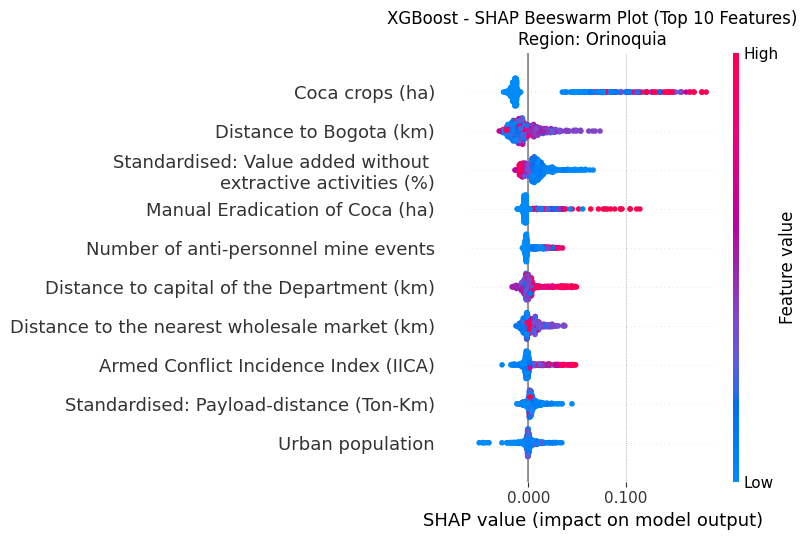

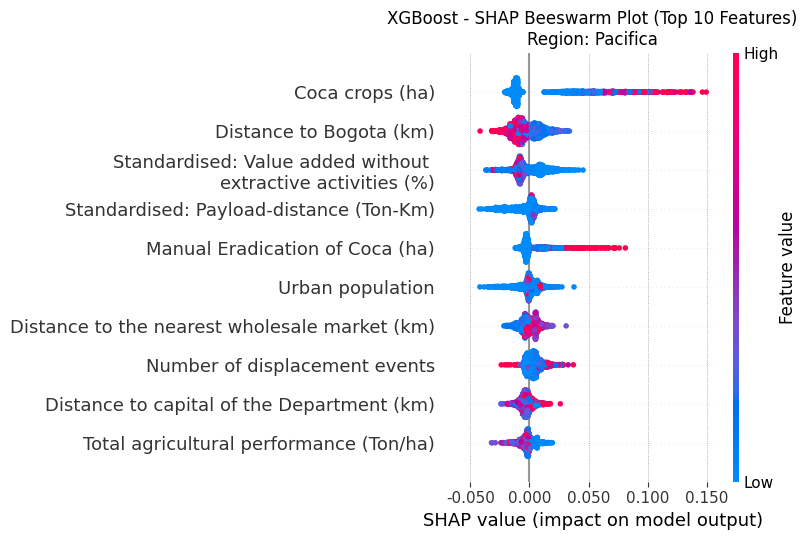

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# Loop through each unique region
for region_label in sorted(final_df['Region'].unique()):
    # Identify indices for the current region (make sure indices align between X_train and final_df)
    region_indices = final_df[final_df['Region'] == region_label].index
    mask = X_train.index.isin(region_indices)
    
    # Subset the SHAP explanation for this region
    shap_region = shap.Explanation(
        values=shap_values.values[mask],
        base_values=shap_values.base_values[mask],
        data=shap_values.data[mask],
        feature_names=shap_values.feature_names
    )
    
    # Convert to DataFrame to compute the mean absolute SHAP values per feature
    shap_region_df = pd.DataFrame(shap_region.values, columns=shap_region.feature_names)
    mean_abs = shap_region_df.abs().mean()
    
    # Get the top 10 features for the Region (sorted in descending order)
    top10_features = mean_abs.sort_values(ascending=False).head(10).index
    
    # Determine the corresponding column indices for these top features
    top10_indices = [list(shap_region.feature_names).index(feat) for feat in top10_features]
    
    # Create a list of custom feature names using your rename dictionary; if a feature is not in the dict, keep its original name.
    custom_feature_names = [rename_dict.get(feat, feat) for feat in top10_features]
    
    # Create a new SHAP Explanation with only the top 10 features
    shap_values_top10 = shap.Explanation(
        values=shap_region.values[:, top10_indices],
        base_values=shap_region.base_values,
        data=shap_region.data[:, top10_indices],
        feature_names=custom_feature_names
    )
    
    # Create a figure for the beeswarm plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot the beeswarm plot using the subset SHAP Explanation
    shap.plots.beeswarm(shap_values_top10, show=False)
    
    # Customizations: Remove spines and add dotted grid lines along x-axis
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(axis='x', color='gray', linestyle=':', linewidth=0.5)
    
    # Format x-axis tick labels to show up to 3 decimal places
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    # Set title and layout
    plt.title(f"XGBoost - SHAP Beeswarm Plot (Top 10 Features)\nRegion: {region_label}")
    plt.tight_layout()
    plt.show()